In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import ccxt

import talib

import ipywidgets as widgets
from IPython.display import display

In [24]:
price_df = pd.read_csv('dataset/BTCUSDT-1min.csv',
                 index_col='date',
                 parse_dates=['date'])
price_df = price_df[['open', 'high', 'low', 'close']]
price_df.sort_index(inplace=True)
price_df = price_df.loc['2018-01-01':]
price_df = price_df.resample('1d').first()
price_df

,open,high,low,close
date,,,,
2018-01-01,13715.65,13715.65,13681.00,13707.92
2018-01-02,13382.16,13458.00,13382.16,13436.41
2018-01-03,14690.00,14726.73,14675.11,14700.00
2018-01-04,14919.51,14919.51,14869.33,14897.96
2018-01-05,15059.56,15096.99,15059.56,15094.99
...,...,...,...,...
2021-08-31,46982.91,46982.91,46900.02,46920.74
2021-09-01,47100.89,47103.64,47038.74,47050.49
2021-09-02,48810.51,48852.53,48775.11,48852.52


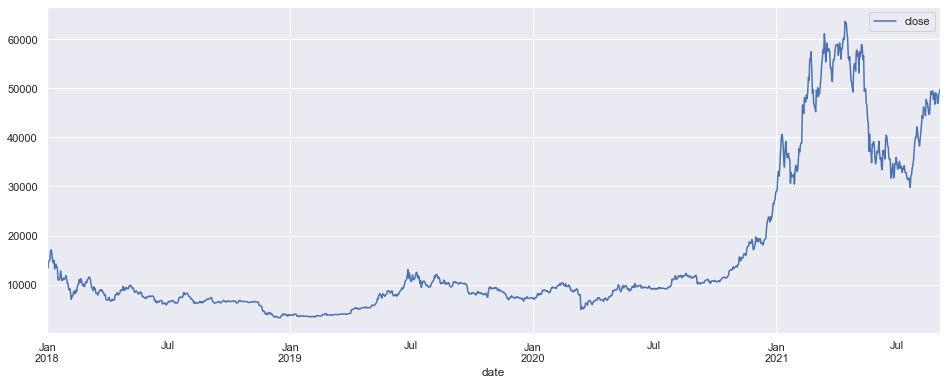

In [25]:
price_df.plot(y='close', figsize=(16, 6))

In [26]:
price_df['return'] = price_df['close'].pct_change()
price_df['return_MA'] = price_df['return'].rolling(30).mean()
price_df['return_std'] = price_df['return'].rolling(30).std()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x132315c70>,
      dtype=object)

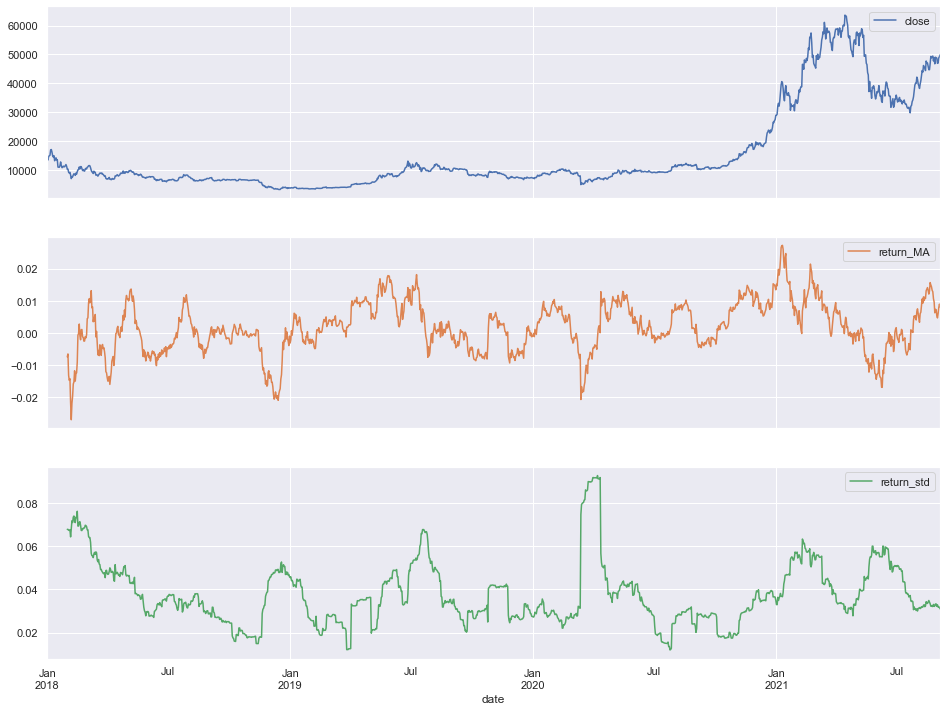

In [27]:
price_df.plot(y=['close', 'return_MA', 'return_std'], figsize=(16, 12), subplots=True)

In [28]:
def cross_up(vector_a, vector_b):
    prev_vector_a = vector_a.shift(1)
    return (vector_a > vector_b) & (prev_vector_a < vector_b)

def cross_down(vector_a, vector_b):
    prev_vector_a = vector_a.shift(1)
    return (vector_a < vector_b) & (prev_vector_a > vector_b)

def cross_over(vector_a, vector_b):
    return cross_up(vector_a, vector_b).astype(int) + cross_down(vector_a, vector_b).astype(int) * (-1)

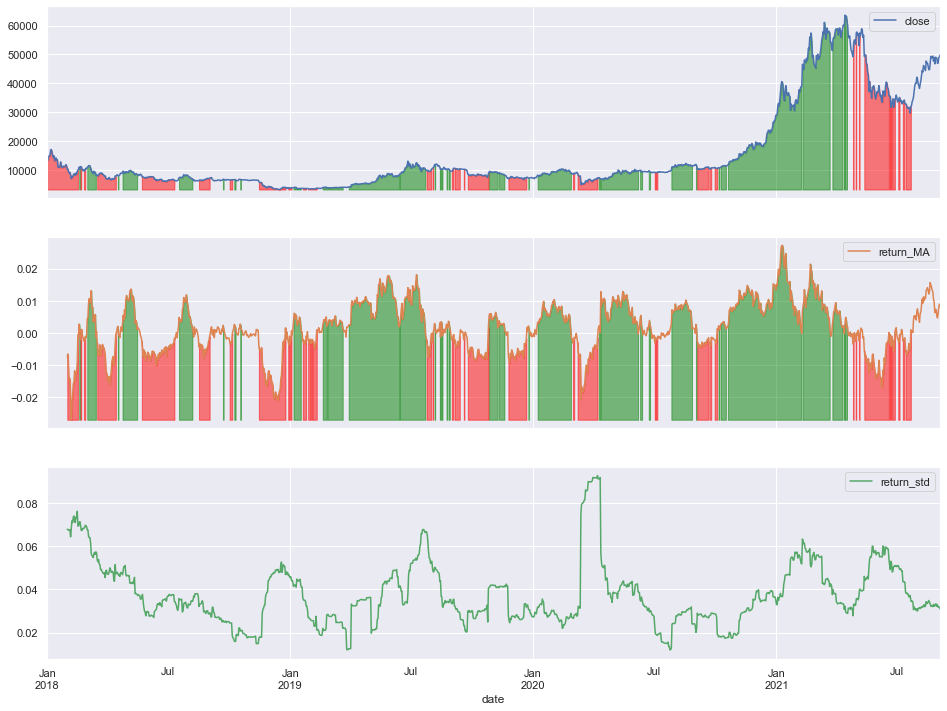

In [31]:

def find_cross_interval(cross_over_signal, start_signal, stop_signal):
    intervals = []

    cross_start_timestamp = None
    for timestamp, signal in cross_over_signal.iteritems():
        if len(intervals) == 0 and cross_start_timestamp is None:

            if signal == stop_signal:
                intervals.append((cross_over_signal.index[0], timestamp))
                continue
        
        if signal == start_signal:
            cross_start_timestamp = timestamp

        if signal == stop_signal:
            cross_end_timestamp = timestamp
            intervals.append((cross_start_timestamp, cross_end_timestamp))
            cross_start_timestamp = None
    return intervals


def plot_trend(upper_bound, lower_bound):
    cross_over_signal = cross_over(price_df['return_MA'], upper_bound)
    bull_intervals = find_cross_interval(cross_over_signal, start_signal=1, stop_signal=-1)
    
    cross_over_signal = cross_over(price_df['return_MA'], lower_bound)
    bear_intervals = find_cross_interval(cross_over_signal, start_signal=-1, stop_signal=1)

    def draw_interval(ax, lines, intervals, **kwargs):
        for start, stop in intervals:
            ax.fill_between(pd.date_range(start, stop), lines.min(), lines.loc[start: stop], **kwargs)

    price_ax, return_ax, *_ = price_df.plot(y=['close', 'return_MA', 'return_std'], figsize=(16, 12), subplots=True)

    draw_interval(price_ax, price_df['close'], bull_intervals, color='green', alpha=0.5)
    draw_interval(price_ax, price_df['close'], bear_intervals, color='red', alpha=0.5)

    draw_interval(return_ax, price_df['return_MA'], bull_intervals, color='green', alpha=0.5)
    draw_interval(return_ax, price_df['return_MA'], bear_intervals, color='red', alpha=0.5)

upper_bound = 0.002
lower_bound = -0.002
plot_trend(upper_bound, lower_bound)